In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, MinMaxScaler, MultiLabelBinarizer, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    log_loss, matthews_corrcoef, cohen_kappa_score, classification_report, make_scorer
)
from sklearn.ensemble import (
    HistGradientBoostingClassifier, RandomForestClassifier, VotingClassifier
)
from sklearn.model_selection import cross_val_score, cross_validate
import dill
import os
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import RandomizedSearchCV

from scipy.stats import randint, uniform


## Divide training sets by male and female 

In [3]:
from sklearn.model_selection import train_test_split

Company = pd.read_csv("Company.csv")
satisfy = Company.copy()
fulfill = Company.copy()

satisfy = satisfy[[column for column in satisfy.columns if column != "q61"] + ["q61"]]  
fulfill = fulfill[[column for column in fulfill.columns if column != "q62"] + ["q62"]]  

satisfy_male = satisfy[satisfy["q71"] == 1].copy()
satisfy_female = satisfy[satisfy["q71"] == 2].copy()

fulfill_male = fulfill[fulfill["q71"] == 1].copy()
fulfill_female = fulfill[fulfill["q71"] == 2].copy()

# For satisfaction (q61)
satisfy_male_train, satisfy_male_test = train_test_split(
    satisfy_male, test_size=0.2, random_state=42, stratify=satisfy_male["q61"]
)

satisfy_female_train, satisfy_female_test = train_test_split(
    satisfy_female, test_size=0.2, random_state=42, stratify=satisfy_female["q61"]
)

# For fulfillment (q62)
fulfill_male_train, fulfill_male_test = train_test_split(
    fulfill_male, test_size=0.2, random_state=42, stratify=fulfill_male["q62"]
)

fulfill_female_train, fulfill_female_test = train_test_split(
    fulfill_female, test_size=0.2, random_state=42, stratify=fulfill_female["q62"]
)


## Preprocessing Functions 

In [4]:
class MultiHotEncoder(BaseEstimator, TransformerMixin):
    """Wraps `MultiLabelBinarizer` in a form that can work with `ColumnTransformer`. Note
    that input X has to be a `pandas.DataFrame`.
    """
    def __init__(self):
        self.mlbs = list()
        self.n_columns = 0
        self.categories_ = self.classes_ = list()

    def fit(self, X:pd.DataFrame, y=None):
        for i in range(len(X.columns)): # X can be of multiple columns
            mlb = MultiLabelBinarizer()
            
            col_data = X.iloc[:, i].dropna().apply(
                lambda x: [item.strip() for item in x.split(",")] if isinstance(x, str) else []
            )
            
            mlb.fit(col_data)
            self.mlbs.append(mlb)
            self.classes_.append(mlb.classes_)
            self.n_columns += 1
        return self

    def transform(self, X:pd.DataFrame):
        if self.n_columns == 0:
            raise ValueError('Please fit the transformer first.')
        if self.n_columns != X.shape[1]:
            raise ValueError(f'The fit transformer deals with {self.n_columns} columns '
                             f'while the input has {X.shape[1]}.'
                            )
        result = list()
        
        for i in range(self.n_columns):
            # col_data = X.iloc[:, i].dropna().apply(
            #     lambda x: [item.strip() for item in x.split(",")] if isinstance(x, str) else []
            # )
            col_data = X.iloc[:, i].apply(
                lambda x: [item.strip() for item in x.split(",")] if isinstance(x, str) else []
            )

            result.append(self.mlbs[i].transform(col_data))

        result = np.concatenate(result, axis=1)
        return result
    
    def get_feature_names_out(self, input_features):
        feature_names = []
        for i, col in enumerate(input_features):
            feature_names.extend([f"{col}_{cat}" for cat in self.categories_[i]])
        return feature_names

# Function transformer for computing duration (amount of time spent on the form)
def compute_duration(X):
    if isinstance(X, pd.DataFrame):
        start = pd.to_datetime(X.iloc[:, 0])
        end = pd.to_datetime(X.iloc[:, 1])

    duration = (end - start).dt.total_seconds()
    return duration.values.reshape(-1, 1)

# Function transformer for binary encoding 
def binary_transform(X):
    return (X - 1).astype(int)

def remove_trolls(df, lower=480, upper=np.inf):
    start = pd.to_datetime(df["form_start"])
    end = pd.to_datetime(df["form_end"])
    duration = (end - start).dt.total_seconds()

    mask = (duration >= lower) & (duration <= upper)
    return df.loc[mask].reset_index(drop=True)  # Reset index to avoid alignment issues later



## Satisfy Male 

In [9]:
drop_features = ["form_start","form_end","q71","q22","q31"]
binary_features = [f"q{str(i).zfill(2)}" for i in range(1, 61) if i not in [22, 31]] + ["q72"]

multi_label_binary = ["q63","q64","q65","q66","q67","q74", "q73"]
one_hot_features = ["q68","q69","q70"]

psm = ColumnTransformer([
    ("duration_pipeline", Pipeline([
        ("compute", FunctionTransformer(compute_duration, validate=False, 
            feature_names_out=lambda self, input_features: np.array(["duration"]))),
        ("scale", MinMaxScaler())
    ]), drop_features),
    ("drop_cols", "drop", drop_features),  
    ("minmax_q62", MinMaxScaler(), ["q62"]),
    ("binary_encoding", FunctionTransformer(binary_transform, validate=False, feature_names_out='one-to-one'), binary_features), 
    ("multiselect", MultiHotEncoder(), multi_label_binary),
    ("onehot", OneHotEncoder(handle_unknown="ignore",sparse_output=False), one_hot_features),
], remainder="passthrough")  

os.makedirs("saved_models", exist_ok=True)

X_train = satisfy_male_train.drop(columns=["q61"])
y_train = satisfy_male_train["q61"]

def evaluate_model(name, classifier):
    pipeline = Pipeline([
        ("preprocessing", psm),
        ("classifier", classifier)
    ])
    scoring = {
        'accuracy': 'accuracy',
        'mcc': make_scorer(matthews_corrcoef),
        'f1': 'f1_macro',
        'precision': make_scorer(precision_score, zero_division=1, average='macro'),
        'recall': make_scorer(recall_score, zero_division=1, average='macro')
    }

    cv_results = cross_validate(pipeline, X_train, y_train, cv=4, scoring=scoring, return_train_score=True, n_jobs=-1)

    print(f"\n{name}")
    print(f"{'Metric':<20}{'Train Avg':>12}{'Test Avg':>12}")
    print("-" * 60)
    for metric in scoring:
        train_scores = cv_results[f"train_{metric}"]
        test_scores = cv_results[f"test_{metric}"]
        print(f"{metric:<20}{np.mean(train_scores):>12.4f}{np.mean(test_scores):>12.4f}")
    
    # Return both: scores and the pipeline
    return {metric: cv_results[f"test_{metric}"] for metric in scoring}, pipeline

base_models = [
    ("Voting", VotingClassifier(n_jobs=-1  ,estimators=[
        ("hgb", HistGradientBoostingClassifier(
            learning_rate=0.02883701168472723, max_iter=312, max_leaf_nodes=37, min_samples_leaf=15,
            max_depth=7, l2_regularization=0.3398231196727128, early_stopping=True,
            n_iter_no_change=15, random_state=42, class_weight="balanced"
        )),
        ("RandomForest", RandomForestClassifier(
            n_estimators=379,             
            max_depth=18,              
            min_samples_split=5,         
            min_samples_leaf=3,           
            max_features="sqrt",      
            class_weight="balanced",     
            bootstrap=False,              
            random_state=42,
            n_jobs=-1                    
        )),
    ], voting='hard')),
]

cv_scores_sm = {}

for name, clf in base_models:
    model_scores, pipeline = evaluate_model(name, clf)  

    for metric, scores in model_scores.items():
        if metric not in cv_scores_sm:
            cv_scores_sm[metric] = {}
        cv_scores_sm[metric][name] = scores

    pipeline.fit(X_train, y_train)

    filename = "ec.dill"
    with open(filename, "wb") as f:
        dill.dump(clf, f)

    
# Final test set evaluation
# pipeline.fit(X_train, y_train)

# X_test = satisfy_male_test.drop(columns=["q61"])
# y_test = satisfy_male_test["q61"]

# y_pred = pipeline.predict(X_test)

# print("\nFinal Evaluation on Test Set (satisfy_male_test):")
# print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
# print(f"F1 Score: {f1_score(y_test, y_pred, average='macro'):.4f}")
# print(f"Precision: {precision_score(y_test, y_pred, average='macro', zero_division=1):.4f}")
# print(f"Recall: {recall_score(y_test, y_pred, average='macro', zero_division=1):.4f}")
# print(f"MCC: {matthews_corrcoef(y_test, y_pred):.4f}")


Voting
Metric                 Train Avg    Test Avg
------------------------------------------------------------
accuracy                  0.9299      0.6168
mcc                       0.8926      0.3918
f1                        0.8947      0.5333
precision                 0.8570      0.5263
recall                    0.9560      0.5554


## MEOW

In [5]:
#meow
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

original_company = pd.read_csv("Company.csv")

satisfy_tasnim = original_company.copy()
satisfy_tasnim = satisfy_tasnim[[col for col in satisfy_tasnim.columns if col != 'q61'] + ['q61']]

satisfy_training_tasnim, satisfy_test_tasnim = train_test_split(
    satisfy_tasnim, test_size=0.20, random_state=42, shuffle=True, stratify=satisfy_tasnim["q61"]
)


class MultiHotEncoder(BaseEstimator, TransformerMixin):
    """Wraps `MultiLabelBinarizer` in a form that can work with `ColumnTransformer`. Note
    that input X has to be a `pandas.DataFrame`.
    """
    def __init__(self):
        self.mlbs = list()
        self.n_columns = 0
        self.categories_ = self.classes_ = list()

    def fit(self, X:pd.DataFrame, y=None):
        for i in range(len(X.columns)): # X can be of multiple columns
            mlb = MultiLabelBinarizer()
            
            col_data = X.iloc[:, i].dropna().apply(
                lambda x: [item.strip() for item in x.split(",")] if isinstance(x, str) else []
            )
            
            mlb.fit(col_data)
            self.mlbs.append(mlb)
            self.classes_.append(mlb.classes_)
            self.n_columns += 1
        return self

    def transform(self, X:pd.DataFrame):
        if self.n_columns == 0:
            raise ValueError('Please fit the transformer first.')
        if self.n_columns != X.shape[1]:
            raise ValueError(f'The fit transformer deals with {self.n_columns} columns '
                             f'while the input has {X.shape[1]}.'
                            )
        result = list()
        
        for i in range(self.n_columns):

            col_data = X.iloc[:, i].apply(
                lambda x: [item.strip() for item in x.split(",")] if isinstance(x, str) else []
            )

            result.append(self.mlbs[i].transform(col_data))

        result = np.concatenate(result, axis=1)
        return result
    
    def get_feature_names_out(self, input_features):
        feature_names = []
        for i, col in enumerate(input_features):
            feature_names.extend([f"{col}_{cat}" for cat in self.categories_[i]])
        return feature_names

# Function transformer for computing duration (amount of time spent on the form)
def compute_duration(X):
    if isinstance(X, pd.DataFrame):
        start = pd.to_datetime(X.iloc[:, 0])
        end = pd.to_datetime(X.iloc[:, 1])

    duration = (end - start).dt.total_seconds()
    return duration.values.reshape(-1, 1)

# Function transformer for binary encoding 
def binary_transform(X):
    return (X - 1).astype(int)


drop_features = ["form_start","form_end"]
binary_features = [f"q{str(i).zfill(2)}" for i in range(1, 61)] + ["q71", "q72"]
multi_label_binary = ["q63","q64","q65","q66","q67","q74","q73"]
one_hot_features = ["q68","q69","q70"]

# Define Preprocessor for satisfy
preprocessor = ColumnTransformer([
    ("duration_pipeline", Pipeline([
        ("compute", FunctionTransformer(compute_duration, validate=False, 
            feature_names_out=lambda self, input_features: np.array(["duration"]))),
        ("scale", MinMaxScaler())
    ]), drop_features),
    ("drop_cols", "drop", drop_features),  
    ("minmax_q62", MinMaxScaler(), ["q62"]),
    ("binary_encoding", FunctionTransformer(binary_transform, validate=False, feature_names_out='one-to-one'), binary_features), 
    ("multiselect", MultiHotEncoder(), multi_label_binary),
    ("onehot", OneHotEncoder(handle_unknown="ignore",sparse_output=False), one_hot_features),
], remainder="passthrough")  


satisfy_pipeline = Pipeline([
    ("preprocessing", preprocessor)
])


preprocessor.fit(satisfy_training_tasnim)
satisfied_array = satisfy_pipeline.fit_transform(satisfy_training_tasnim)

transformed_cols = preprocessor.get_feature_names_out()
transformed_cols = [col.split("__")[-1] for col in transformed_cols]  
satisfied = pd.DataFrame(satisfied_array, columns=transformed_cols)


os.makedirs("saved_models", exist_ok=True)

free = remove_trolls(satisfy_training_tasnim,300)
X_train = free.drop(columns=["q61"])
y_train = free["q61"]


def evaluate_model(name, classifier):
    pipeline = Pipeline([
        ("preprocessing", preprocessor),
        ("classifier", classifier)
    ])
    
    scoring = {
        'accuracy': 'accuracy',
        'mcc': make_scorer(matthews_corrcoef),
        'f1': 'f1_macro',
        'precision': make_scorer(precision_score, zero_division=1, average='macro'),
        'recall': make_scorer(recall_score, zero_division=1, average='macro')
    }

    cv_results = cross_validate(pipeline, X_train, y_train, cv=4, scoring=scoring, return_train_score=True, n_jobs=-1)

    print(f"\n{name}")
    print(f"{'Metric':<20}{'Train Avg':>12}{'Test Avg':>12}")
    print("-" * 60)
    for metric in scoring:
        train_scores = cv_results[f"train_{metric}"]
        test_scores = cv_results[f"test_{metric}"]
        print(f"{metric:<20}{np.mean(train_scores):>12.4f}{np.mean(test_scores):>12.4f}")
    
    # Return both: scores and the pipeline
    return {metric: cv_results[f"test_{metric}"] for metric in scoring}, pipeline


# Define models
base_models = [
        ("Voting", VotingClassifier(n_jobs=-1  ,estimators=[
        ("hgb", HistGradientBoostingClassifier(
            learning_rate=0.03, max_iter=300, max_leaf_nodes=31, min_samples_leaf=20,
            max_depth=7, l2_regularization=0.2, early_stopping=False,
            n_iter_no_change=15, random_state=42
        )),
        ("RandomForest", RandomForestClassifier(
            n_estimators=300,             
            max_depth=20,              
            min_samples_split=5,         
            min_samples_leaf=4,           
            max_features="sqrt",      
            class_weight="balanced",     
            bootstrap=False,              
            random_state=42,
            n_jobs=-1                    
        )),
        
    ], voting='soft')),
]


In [47]:
cv_scores = {}

for name, clf in base_models:
    model_scores, pipeline = evaluate_model(name, clf)  

    for metric, scores in model_scores.items():
        if metric not in cv_scores:
            cv_scores[metric] = {}
        cv_scores[metric][name] = scores

    pipeline.fit(X_train, y_train)
    
    filename = "new.dill"
    with open(filename, "wb") as f:
        dill.dump(clf, f)



Voting
Metric                 Train Avg    Test Avg
------------------------------------------------------------
accuracy                  0.9244      0.6731
mcc                       0.8702      0.4232
f1                        0.9449      0.5108
precision                 0.9406      0.5697
recall                    0.9495      0.4865


In [8]:
satisfy_test_tasnim.to_csv("test_satisfy.csv")
satisfy_training_tasnim.to_csv("train_satisfy.csv")

In [10]:
#fulfill
original_company = pd.read_csv("Company.csv")

fulfill_tasnim = original_company.copy()
fulfill_tasnim = fulfill_tasnim[[col for col in fulfill_tasnim.columns if col != 'q62'] + ['q62']]

fulfill_training_tasnim, fulfill_test_tasnim = train_test_split(
    fulfill_tasnim, test_size=0.20, random_state=42, shuffle=True, stratify=fulfill_tasnim["q62"]
)


class MultiHotEncoder(BaseEstimator, TransformerMixin):
    """Wraps `MultiLabelBinarizer` in a form that can work with `ColumnTransformer`. Note
    that input X has to be a `pandas.DataFrame`.
    """
    def __init__(self):
        self.mlbs = list()
        self.n_columns = 0
        self.categories_ = self.classes_ = list()

    def fit(self, X:pd.DataFrame, y=None):
        for i in range(len(X.columns)): # X can be of multiple columns
            mlb = MultiLabelBinarizer()
            
            col_data = X.iloc[:, i].dropna().apply(
                lambda x: [item.strip() for item in x.split(",")] if isinstance(x, str) else []
            )
            
            mlb.fit(col_data)
            self.mlbs.append(mlb)
            self.classes_.append(mlb.classes_)
            self.n_columns += 1
        return self

    def transform(self, X:pd.DataFrame):
        if self.n_columns == 0:
            raise ValueError('Please fit the transformer first.')
        if self.n_columns != X.shape[1]:
            raise ValueError(f'The fit transformer deals with {self.n_columns} columns '
                             f'while the input has {X.shape[1]}.'
                            )
        result = list()
        
        for i in range(self.n_columns):

            col_data = X.iloc[:, i].apply(
                lambda x: [item.strip() for item in x.split(",")] if isinstance(x, str) else []
            )

            result.append(self.mlbs[i].transform(col_data))

        result = np.concatenate(result, axis=1)
        return result
    
    def get_feature_names_out(self, input_features):
        feature_names = []
        for i, col in enumerate(input_features):
            feature_names.extend([f"{col}_{cat}" for cat in self.categories_[i]])
        return feature_names

# Function transformer for computing duration (amount of time spent on the form)
def compute_duration(X):
    if isinstance(X, pd.DataFrame):
        start = pd.to_datetime(X.iloc[:, 0])
        end = pd.to_datetime(X.iloc[:, 1])

    duration = (end - start).dt.total_seconds()
    return duration.values.reshape(-1, 1)

# Function transformer for binary encoding 
def binary_transform(X):
    return (X - 1).astype(int)


drop_features = ["form_start","form_end"]
binary_features = [f"q{str(i).zfill(2)}" for i in range(1, 61)] + ["q71", "q72"]
multi_label_binary = ["q63","q64","q65","q66","q67","q74","q73"]
one_hot_features = ["q68","q69","q70"]

# Define Preprocessor for satisfy
f_preprocessor = ColumnTransformer([
    ("duration_pipeline", Pipeline([
        ("compute", FunctionTransformer(compute_duration, validate=False, 
            feature_names_out=lambda self, input_features: np.array(["duration"]))),
        ("scale", MinMaxScaler())
    ]), drop_features),
    ("drop_cols", "drop", drop_features),  
    ("minmax_q62", MinMaxScaler(), ["q61"]),
    ("binary_encoding", FunctionTransformer(binary_transform, validate=False, feature_names_out='one-to-one'), binary_features), 
    ("multiselect", MultiHotEncoder(), multi_label_binary),
    ("onehot", OneHotEncoder(handle_unknown="ignore",sparse_output=False), one_hot_features),
], remainder="passthrough")  


fulfill_pipeline = Pipeline([
    ("preprocessing", f_preprocessor)
])



satisfied_array = f_preprocessor.fit_transform(fulfill_training_tasnim)

transformed_cols = f_preprocessor.get_feature_names_out()
transformed_cols = [col.split("__")[-1] for col in transformed_cols]  
satisfied = pd.DataFrame(satisfied_array, columns=transformed_cols)


os.makedirs("saved_models", exist_ok=True)

free = remove_trolls(fulfill_training_tasnim,300)
X_train = free.drop(columns=["q62"])
y_train = free["q62"]


def evaluate_model(name, classifier):
    pipeline = Pipeline([
        ("preprocessing", f_preprocessor),
        ("classifier", classifier)
    ])
    
    scoring = {
        'accuracy': 'accuracy',
        'mcc': make_scorer(matthews_corrcoef),
        'f1': 'f1_macro',
        'precision': make_scorer(precision_score, zero_division=1, average='macro'),
        'recall': make_scorer(recall_score, zero_division=1, average='macro')
    }

    cv_results = cross_validate(pipeline, X_train, y_train, cv=4, scoring=scoring, return_train_score=True, n_jobs=-1)

    print(f"\n{name}")
    print(f"{'Metric':<20}{'Train Avg':>12}{'Test Avg':>12}")
    print("-" * 60)
    for metric in scoring:
        train_scores = cv_results[f"train_{metric}"]
        test_scores = cv_results[f"test_{metric}"]
        print(f"{metric:<20}{np.mean(train_scores):>12.4f}{np.mean(test_scores):>12.4f}")
    
    # Return both: scores and the pipeline
    return {metric: cv_results[f"test_{metric}"] for metric in scoring}, pipeline


# Define models
base_models = [        
        ("Voting", VotingClassifier(n_jobs=-1  ,estimators=[
        ("hgb", HistGradientBoostingClassifier(
            learning_rate=0.03, max_iter=300, max_leaf_nodes=31, min_samples_leaf=20,
            max_depth=7, l2_regularization=0.2, early_stopping=False,
            n_iter_no_change=15, random_state=42
        )),
        ("RandomForest", RandomForestClassifier(
            n_estimators=300,             
            max_depth=20,              
            min_samples_split=5,         
            min_samples_leaf=4,           
            max_features="sqrt",      
            class_weight="balanced",     
            bootstrap=False,              
            random_state=42,
            n_jobs=-1                    
        )),
        
    ], voting='hard')),
]


    
cv_scores = {}

for name, clf in base_models:
    model_scores, pipeline = evaluate_model(name, clf)  

    for metric, scores in model_scores.items():
        if metric not in cv_scores:
            cv_scores[metric] = {}
        cv_scores[metric][name] = scores

    pipeline.fit(X_train, y_train)
    
    filename = "fulfill_RubberCorn.dill"
    # with open(filename, "wb") as f:
    #     dill.dump(clf, f)




Voting
Metric                 Train Avg    Test Avg
------------------------------------------------------------
accuracy                  0.9196      0.6229
mcc                       0.8785      0.4011
f1                        0.9313      0.5144
precision                 0.9130      0.5548
recall                    0.9572      0.5002


In [11]:
fulfill_test_tasnim.to_csv("test_fulfill.csv")
fulfill_training_tasnim.to_csv("train_fulfill.csv")

## Preprocessing Steps Testing Block for Satisfy Male

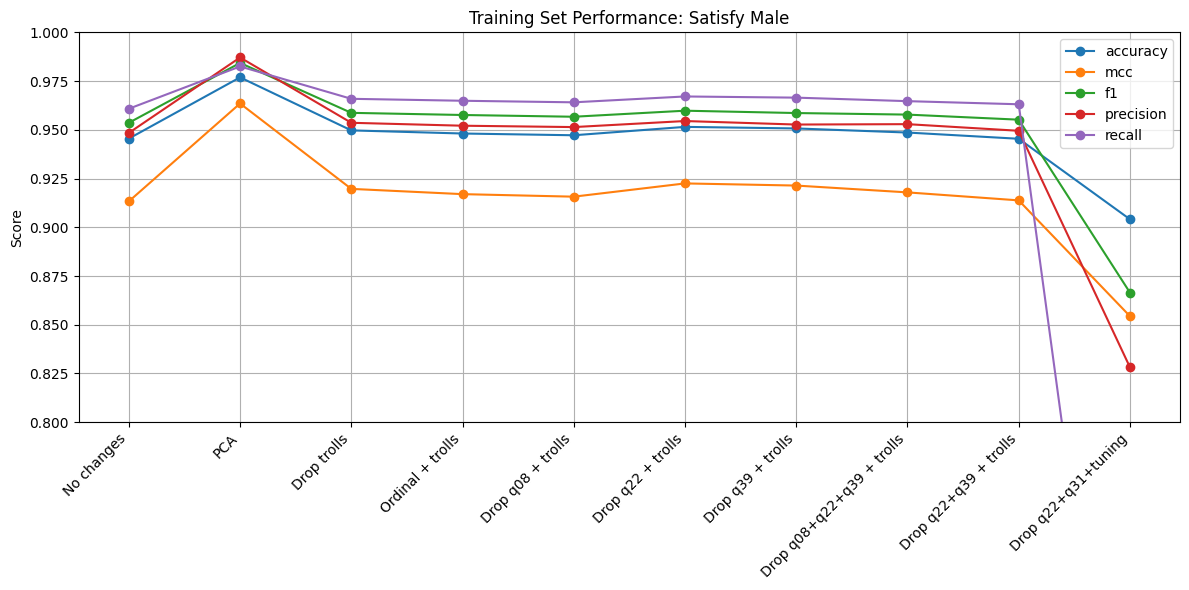

In [104]:
import pandas as pd
import matplotlib.pyplot as plt

# Data from the image
data = {
    "Steps": [
        "No changes",
        "PCA",
        "Drop trolls",
        "Ordinal + trolls",
        "Drop q08 + trolls",
        "Drop q22 + trolls",
        "Drop q39 + trolls",
        "Drop q08+q22+q39 + trolls",
        "Drop q22+q39 + trolls",
        "Drop q22+q31+tuning"
    ],
    "accuracy": [0.9455, 0.9769, 0.9497, 0.9481, 0.9472, 0.9515, 0.9507, 0.9486, 0.9454, 0.9041],
    "mcc": [0.9133, 0.9635, 0.9197, 0.9170, 0.9157, 0.9225, 0.9214, 0.9179, 0.9138, 0.8544],
    "f1": [0.9536, 0.9843, 0.9587, 0.9576, 0.9567, 0.9598, 0.9586, 0.9578, 0.9552, 0.8665],
    "precision": [0.9484, 0.9871, 0.9536, 0.9521, 0.9514, 0.9545, 0.9527, 0.9529, 0.9495, 0.8282],
    "recall": [0.9608, 0.9825, 0.9659, 0.9649, 0.9641, 0.9671, 0.9665, 0.9647, 0.9631, 0.5423]
}

df = pd.DataFrame(data)
df.set_index("Steps", inplace=True)

# Plotting
plt.figure(figsize=(12, 6))
for metric in df.columns:
    plt.plot(df.index, df[metric], marker="o", label=metric)

plt.title("Training Set Performance: Satisfy Male")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Score")
plt.ylim(0.8, 1.0)
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()


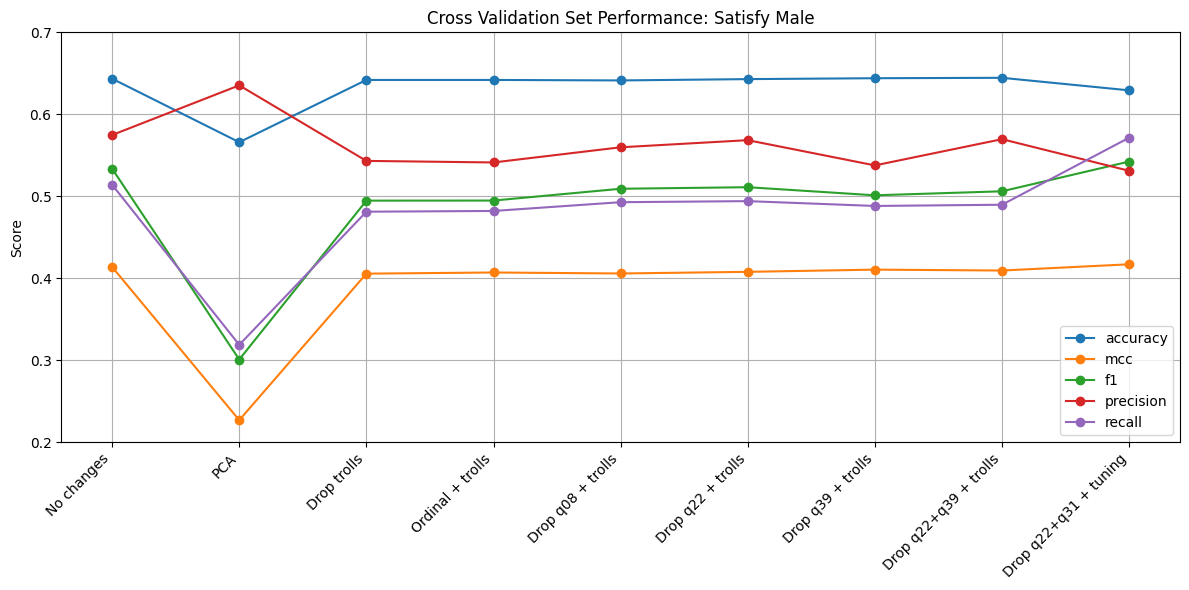

In [108]:
import pandas as pd
import matplotlib.pyplot as plt

# Replace with actual values from the image
data = {
    "Steps": [
        "No changes",
        "PCA",
        "Drop trolls",
        "Ordinal + trolls",
        "Drop q08 + trolls",
        "Drop q22 + trolls",
        "Drop q39 + trolls",
        "Drop q22+q39 + trolls",
        "Drop q22+q31 + tuning"
    ],
    "accuracy": [0.6434, 0.5659, 0.6419, 0.6419, 0.6413, 0.6429, 0.6440, 0.6445, 0.6292],
    "mcc": [0.4137, 0.2267, 0.4055, 0.4069, 0.4057, 0.4077, 0.4104, 0.4093, 0.4169],
    "f1": [0.5336, 0.3007, 0.4946, 0.4947, 0.5091, 0.5110, 0.5011, 0.5060, 0.5423],
    "precision": [0.5747, 0.6353, 0.5431, 0.5412, 0.5597, 0.5684, 0.5376, 0.5696, 0.5310],
    "recall": [0.5140, 0.3186, 0.4811, 0.4820, 0.4927, 0.4940, 0.4881, 0.4896, 0.5714]
}


df = pd.DataFrame(data)
df.set_index("Steps", inplace=True)

# Plotting
plt.figure(figsize=(12, 6))
for metric in df.columns:
    plt.plot(df.index, df[metric], marker="o", label=metric)

plt.title("Cross Validation Set Performance: Satisfy Male")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Score")
plt.ylim(0.2, 0.7)
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()


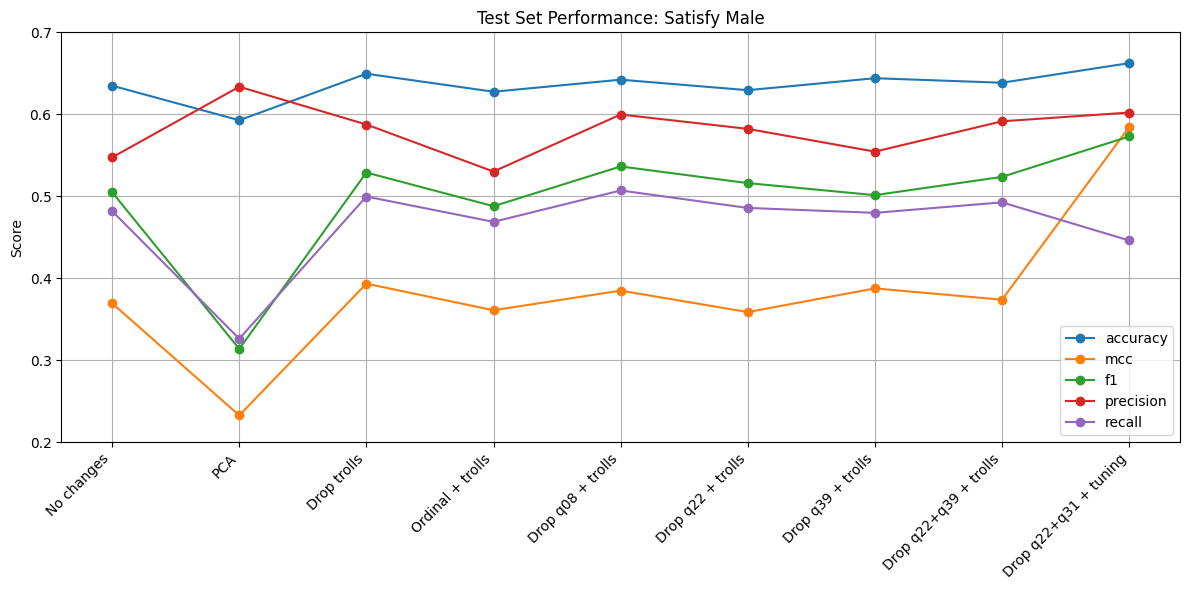

In [106]:
import pandas as pd
import matplotlib.pyplot as plt

# Replace with actual values from the image
data = {
    "Steps": [
        "No changes",
        "PCA",
        "Drop trolls",
        "Ordinal + trolls",
        "Drop q08 + trolls",
        "Drop q22 + trolls",
        "Drop q39 + trolls",
        "Drop q22+q39 + trolls",
        "Drop q22+q31 + tuning"
    ],
    "accuracy": [0.6349, 0.5927, 0.6495, 0.6275, 0.6422, 0.6294, 0.6440, 0.6385, 0.6624],
    "mcc": [0.3693, 0.2325, 0.3933, 0.3608, 0.3848, 0.3586, 0.3875, 0.3737, 0.5845],
    "f1": [0.5049, 0.3136, 0.5289, 0.4878, 0.5363, 0.5160, 0.5013, 0.5236, 0.5729],
    "precision": [0.5474, 0.6336, 0.5875, 0.5301, 0.5997, 0.5822, 0.5544, 0.5914, 0.6021],
    "recall": [0.4818, 0.3260, 0.4996, 0.4687, 0.5070, 0.4857, 0.4797, 0.4925, 0.4460]
}

df = pd.DataFrame(data)
df.set_index("Steps", inplace=True)

# Plotting
plt.figure(figsize=(12, 6))
for metric in df.columns:
    plt.plot(df.index, df[metric], marker="o", label=metric)

plt.title("Test Set Performance: Satisfy Male")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Score")
plt.ylim(0.2, 0.7)
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()


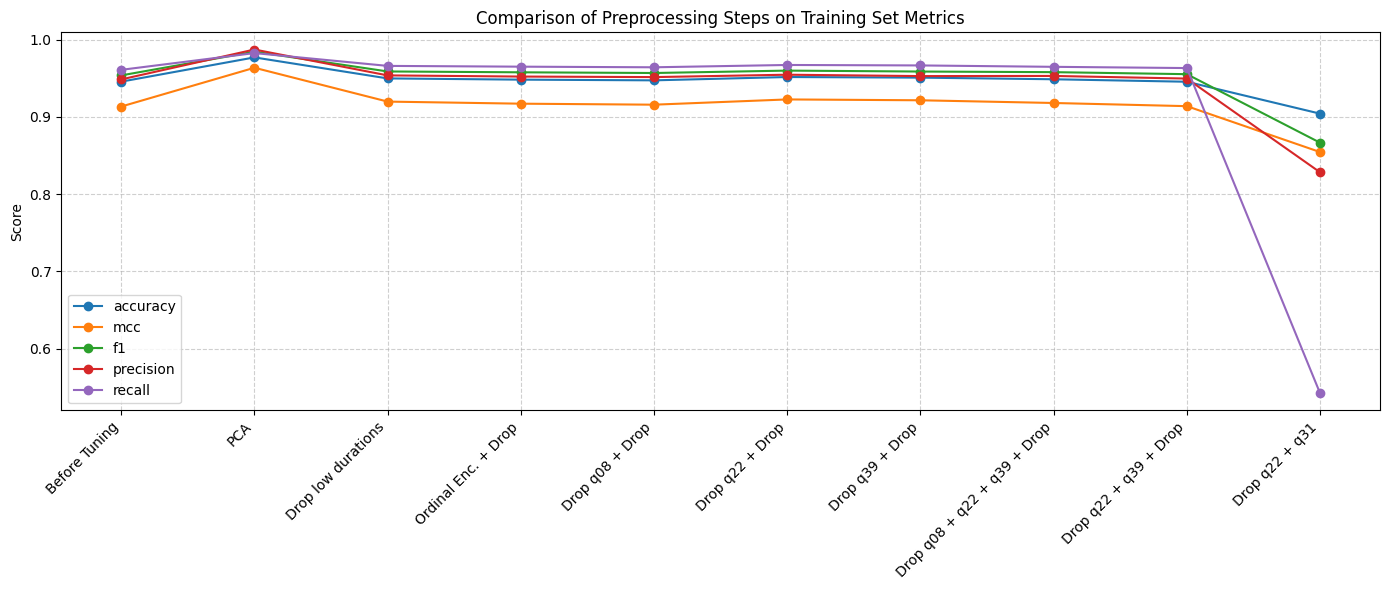

In [101]:
import pandas as pd
import matplotlib.pyplot as plt

# Manually input the data from the image
data = {
    "Steps": [
        "Before Tuning",
        "PCA",
        "Drop low durations",
        "Ordinal Enc. + Drop",
        "Drop q08 + Drop",
        "Drop q22 + Drop",
        "Drop q39 + Drop",
        "Drop q08 + q22 + q39 + Drop",
        "Drop q22 + q39 + Drop",
        "Drop q22 + q31"
    ],
    "accuracy": [0.9455, 0.9769, 0.9497, 0.9481, 0.9472, 0.9515, 0.9507, 0.9486, 0.9454, 0.9041],
    "mcc": [0.9133, 0.9635, 0.9197, 0.9170, 0.9157, 0.9225, 0.9214, 0.9179, 0.9138, 0.8544],
    "f1": [0.9536, 0.9843, 0.9587, 0.9576, 0.9567, 0.9598, 0.9586, 0.9578, 0.9552, 0.8665],
    "precision": [0.9484, 0.9871, 0.9536, 0.9521, 0.9514, 0.9545, 0.9527, 0.9529, 0.9495, 0.8282],
    "recall": [0.9608, 0.9825, 0.9659, 0.9649, 0.9641, 0.9671, 0.9665, 0.9647, 0.9631, 0.5423],
}

df = pd.DataFrame(data)
df.set_index("Steps", inplace=True)

# Plot all metrics on the same graph
plt.figure(figsize=(14, 6))
for metric in df.columns:
    plt.plot(df.index, df[metric], marker='o', label=metric)

plt.title("Comparison of Preprocessing Steps on Training Set Metrics")
plt.ylabel("Score")
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


In [55]:
X_train_transformed = psm.fit_transform(X_train, y_train)
feature_names = []

for name, transformer, cols in psm.transformers_:
    if name == "drop_cols":
        continue
    if hasattr(transformer, "get_feature_names_out"):
        if isinstance(cols, list):
            names = transformer.get_feature_names_out(cols)
        else:
            names = transformer.get_feature_names_out()
        feature_names.extend(names)
    else:
        if isinstance(cols, list):
            feature_names.extend(cols)
        else:
            feature_names.append(cols)

X_transformed_df = pd.DataFrame(X_train_transformed, columns=feature_names)


X_transformed_df.corrwith(y_train).sort_values(key=lambda x: abs(x), ascending=False)



q69_6    0.210724
q07      0.208062
q34      0.186722
q66_3   -0.169651
q54     -0.161377
           ...   
q70_2   -0.003528
q63_2   -0.003232
q65_5   -0.001380
q23     -0.001340
q17     -0.000345
Length: 126, dtype: float64

In [145]:
from sklearn.decomposition import PCA

drop_features = ["form_start","form_end","q71","q31","q22"]
binary_features = [f"q{str(i).zfill(2)}" for i in range(1, 61) if i not in [31,22]] + ["q72"]

multi_label_binary = ["q63","q64","q65","q66","q67","q74", "q73"]
one_hot_features = ["q68","q69","q70"]

psm = ColumnTransformer([
    ("duration_pipeline", Pipeline([
        ("compute", FunctionTransformer(compute_duration, validate=False, 
            feature_names_out=lambda self, input_features: np.array(["duration"]))),
        ("scale", MinMaxScaler())
    ]), drop_features),
    ("drop_cols", "drop", drop_features),  
    ("minmax_q62", MinMaxScaler(), ["q62"]),
    ("binary_encoding", FunctionTransformer(binary_transform, validate=False, feature_names_out='one-to-one'), binary_features), 
    ("multiselect", MultiHotEncoder(), multi_label_binary),
    ("onehot", OneHotEncoder(handle_unknown="ignore",sparse_output=False), one_hot_features),
], remainder="passthrough")  


# os.makedirs("saved_models", exist_ok=True)
satisfy_male_train_trollfree = remove_trolls(satisfy_male_train, lower = 300)
# print(len(satisfy_female_train_trollfree))
X_train = satisfy_male_train_trollfree.drop(columns=["q61"])
y_train = satisfy_male_train_trollfree["q61"]

# X_train = satisfy_male_train.drop(columns=["q61"])
# y_train = satisfy_male_train["q61"]

def evaluate_model(name, classifier):
    pipeline = Pipeline([
        ("preprocessing", psm),
        # ("pca", PCA(n_components=.95)),
        ("classifier", classifier)
    ])
    scoring = {
        'accuracy': 'accuracy',
        'mcc': make_scorer(matthews_corrcoef),
        'f1': 'f1_macro',
        'precision': make_scorer(precision_score, zero_division=1, average='macro'),
        'recall': make_scorer(recall_score, zero_division=1, average='macro')
    }

    cv_results = cross_validate(pipeline, X_train, y_train, cv=4, scoring=scoring, return_train_score=True, n_jobs=-1)

    print(f"\n{name}")
    print(f"{'Metric':<20}{'Train Avg':>12}{'Test Avg':>12}")
    print("-" * 60)
    for metric in scoring:
        train_scores = cv_results[f"train_{metric}"]
        test_scores = cv_results[f"test_{metric}"]
        print(f"{metric:<20}{np.mean(train_scores):>12.4f}{np.mean(test_scores):>12.4f}")
    
    # Return both: scores and the pipeline
    return {metric: cv_results[f"test_{metric}"] for metric in scoring}, pipeline
    
base_models = [
    ("Voting", VotingClassifier(n_jobs=-1  ,estimators=[
        ("hgb", HistGradientBoostingClassifier(
            learning_rate=0.02883701168472723, max_iter=312, max_leaf_nodes=37, min_samples_leaf=15,
            max_depth=7, l2_regularization=0.3398231196727128, early_stopping=True,
            n_iter_no_change=15, random_state=42, class_weight="balanced"
        )),
        ("RandomForest", RandomForestClassifier(
            n_estimators=379,             
            max_depth=18,              
            min_samples_split=5,         
            min_samples_leaf=3,           
            max_features="sqrt",      
            class_weight="balanced",     
            bootstrap=False,              
            random_state=42,
            n_jobs=-1                    
        )),
    ], voting='hard')),
]
cv_scores_sm = {}

for name, clf in base_models:
    model_scores, pipeline = evaluate_model(name, clf)  

    for metric, scores in model_scores.items():
        if metric not in cv_scores_sm:
            cv_scores_sm[metric] = {}
        cv_scores_sm[metric][name] = scores

    # pipeline.fit(X_train, y_train)

    # filename = f"saved_models/{name.replace(' ', '_').lower()}.dill"
    # with open(filename, "wb") as f:
    #     dill.dump(pipeline, f)

    
# Final test set evaluation
pipeline.fit(X_train, y_train)

X_test = satisfy_male_test.drop(columns=["q61"])
y_test = satisfy_male_test["q61"]

y_pred = pipeline.predict(X_test)

print("\nFinal Evaluation on Test Set (satisfy_male_test):")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"MCC: {matthews_corrcoef(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred, average='macro'):.4f}")
print(f"Precision: {precision_score(y_test, y_pred, average='macro', zero_division=1):.4f}")
print(f"Recall: {recall_score(y_test, y_pred, average='macro', zero_division=1):.4f}")


Voting
Metric                 Train Avg    Test Avg
------------------------------------------------------------
accuracy                  0.9555      0.6232
mcc                       0.9305      0.3965
f1                        0.9299      0.5212
precision                 0.9042      0.5187
recall                    0.9698      0.5345

Final Evaluation on Test Set (satisfy_male_test):
Accuracy: 0.6037
MCC: 0.3923
F1 Score: 0.5316
Precision: 0.5145
Recall: 0.5772


## Satisfy Female

In [138]:
drop_features = ["form_start","form_end","q71","q35","q08"]
binary_features = [f"q{str(i).zfill(2)}" for i in range(1, 61) if i not in [8,35]] + ["q72"]
multi_label_binary = ["q63","q64","q65","q66","q67","q74", "q73"]
one_hot_features = ["q68","q69","q70"]
psf = ColumnTransformer([
    ("duration_pipeline", Pipeline([
        ("compute", FunctionTransformer(compute_duration, validate=False, 
            feature_names_out=lambda self, input_features: np.array(["duration"]))),
        ("scale", MinMaxScaler())
    ]), drop_features),
    ("drop_cols", "drop", drop_features),  
    ("minmax_q62", MinMaxScaler(), ["q62"]),
    ("binary_encoding", FunctionTransformer(binary_transform, validate=False, feature_names_out='one-to-one'), binary_features), 
    ("multiselect", MultiHotEncoder(), multi_label_binary),
    ("onehot", OneHotEncoder(handle_unknown="ignore",sparse_output=False), one_hot_features),
], remainder="passthrough")  



os.makedirs("saved_models", exist_ok=True)


satisfy_female_train_trollfree = remove_trolls(satisfy_female_train, lower = 500)
# print(len(satisfy_female_train_trollfree))
X_train = satisfy_female_train_trollfree.drop(columns=["q61"])
y_train = satisfy_female_train_trollfree["q61"]


def evaluate_model(name, classifier):
    pipeline = Pipeline([
        ("preprocessing", psf),
        ("classifier", classifier)
    ])
    scoring = {
        'accuracy': 'accuracy',
        'mcc': make_scorer(matthews_corrcoef),
        'f1': 'f1_macro',
        'precision': make_scorer(precision_score, zero_division=1, average='macro'),
        'recall': make_scorer(recall_score, zero_division=1, average='macro')
    }

    cv_results = cross_validate(pipeline, X_train, y_train, cv=4, scoring=scoring, return_train_score=True, n_jobs=-1)

    print(f"\n{name}")
    print(f"{'Metric':<20}{'Train Avg':>12}{'Test Avg':>12}")
    print("-" * 60)
    for metric in scoring:
        train_scores = cv_results[f"train_{metric}"]
        test_scores = cv_results[f"test_{metric}"]
        print(f"{metric:<20}{np.mean(train_scores):>12.4f}{np.mean(test_scores):>12.4f}")
    
    # Return both: scores and the pipeline
    return {metric: cv_results[f"test_{metric}"] for metric in scoring}, pipeline

base_models = [
    ("Voting", VotingClassifier(n_jobs=-1  ,estimators=[
        ("hgb", HistGradientBoostingClassifier(
            learning_rate=0.02883701168472723, max_iter=312, max_leaf_nodes=37, min_samples_leaf=15,
            max_depth=7, l2_regularization=0.3398231196727128, early_stopping=True,
            n_iter_no_change=15, random_state=42, class_weight="balanced"
        )),
        ("RandomForest", RandomForestClassifier(
            n_estimators=379,             
            max_depth=18,              
            min_samples_split=5,         
            min_samples_leaf=3,           
            max_features="sqrt",      
            class_weight="balanced",     
            bootstrap=False,              
            random_state=42,
            n_jobs=-1                    
        )),
    ], voting='hard')),
]

cv_scores_sf = {}

for name, clf in base_models:
    model_scores, pipeline = evaluate_model(name, clf)  

    for metric, scores in model_scores.items():
        if metric not in cv_scores_sf:
            cv_scores_sf[metric] = {}
        cv_scores_sf[metric][name] = scores

    # pipeline.fit(X_train, y_train)

    # filename = f"saved_models/{name.replace(' ', '_').lower()}.dill"
    # with open(filename, "wb") as f:
    #     dill.dump(pipeline, f)

    
# Final test set evaluation
pipeline.fit(X_train, y_train)

X_test = satisfy_female_test.drop(columns=["q61"])
y_test = satisfy_female_test["q61"]

y_pred = pipeline.predict(X_test)

print("\nFinal Evaluation on Test Set (satisfy_female_test):")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred, average='macro'):.4f}")
print(f"Precision: {precision_score(y_test, y_pred, average='macro', zero_division=1):.4f}")
print(f"Recall: {recall_score(y_test, y_pred, average='macro', zero_division=1):.4f}")
print(f"MCC: {matthews_corrcoef(y_test, y_pred):.4f}")


Voting
Metric                 Train Avg    Test Avg
------------------------------------------------------------
accuracy                  0.8583      0.6382
mcc                       0.7704      0.3965
f1                        0.7719      0.5173
precision                 0.7208      0.4910
recall                    0.9081      0.5759

Final Evaluation on Test Set (satisfy_female_test):
Accuracy: 0.6379
F1 Score: 0.5223
Precision: 0.4996
Recall: 0.5659
MCC: 0.4047


In [57]:
X_train_transformed = psf.fit_transform(X_train, y_train)
feature_names = []

for name, transformer, cols in psf.transformers_:
    if name == "drop_cols":
        continue
    if hasattr(transformer, "get_feature_names_out"):
        if isinstance(cols, list):
            names = transformer.get_feature_names_out(cols)
        else:
            names = transformer.get_feature_names_out()
        feature_names.extend(names)
    else:
        if isinstance(cols, list):
            feature_names.extend(cols)
        else:
            feature_names.append(cols)

X_transformed_df = pd.DataFrame(X_train_transformed, columns=feature_names)


X_transformed_df.corrwith(y_train).sort_values(key=lambda x: abs(x), ascending=False)



q62      0.564080
q64_8   -0.206713
q66_3    0.206596
q42     -0.197299
q63_1    0.180906
           ...   
q69_4    0.004921
q69_5    0.004888
q10      0.003718
q74_2   -0.002175
q40      0.000163
Length: 128, dtype: float64

## Preprocessing Test Block Satisfy Female 

In [127]:
# drop_features = ["form_start","form_end","q71","q29","q35"]
# binary_features = [f"q{str(i).zfill(2)}" for i in range(1, 61) if i not in [29,35]] + ["q72"]

# drop_features = ["form_start","form_end","q71","q29"]
# binary_features = [f"q{str(i).zfill(2)}" for i in range(1, 61) if i not in [29]] + ["q72"]
drop_features = ["form_start","form_end","q71","q35"]
binary_features = [f"q{str(i).zfill(2)}" for i in range(1, 61) if i not in [35]] + ["q72"]

# drop_features = ["form_start","form_end","q71","q35"]
# binary_features = [f"q{str(i).zfill(2)}" for i in range(1, 61) if i not in [35]] + ["q72"]

multi_label_binary = ["q63","q64","q65","q66","q67","q74", "q73"]
one_hot_features = ["q68","q69","q70"]
psf = ColumnTransformer([
    ("duration_pipeline", Pipeline([
        ("compute", FunctionTransformer(compute_duration, validate=False, 
            feature_names_out=lambda self, input_features: np.array(["duration"]))),
        ("scale", MinMaxScaler())
    ]), drop_features),
    ("drop_cols", "drop", drop_features),  
    ("minmax_q62", MinMaxScaler(), ["q62"]),
    ("binary_encoding", FunctionTransformer(binary_transform, validate=False, feature_names_out='one-to-one'), binary_features), 
    ("multiselect", MultiHotEncoder(), multi_label_binary),
    ("onehot", OneHotEncoder(handle_unknown="ignore",sparse_output=False), one_hot_features),
], remainder="passthrough")  



os.makedirs("saved_models", exist_ok=True)


satisfy_female_train_trollfree = remove_trolls(satisfy_female_train, lower = 500)
# print(len(satisfy_female_train_trollfree))
X_train = satisfy_female_train_trollfree.drop(columns=["q61"])
y_train = satisfy_female_train_trollfree["q61"]
# X_train = satisfy_female_train.drop(columns=["q61"])
# y_train = satisfy_female_train["q61"]

def evaluate_model(name, classifier):
    pipeline = Pipeline([
        ("preprocessing", psf),
        # ("pca", PCA(n_components=.95)),
        ("classifier", classifier)
    ])
    scoring = {
        'accuracy': 'accuracy',
        'mcc': make_scorer(matthews_corrcoef),
        'f1': 'f1_macro',
        'precision': make_scorer(precision_score, zero_division=1, average='macro'),
        'recall': make_scorer(recall_score, zero_division=1, average='macro')
    }

    cv_results = cross_validate(pipeline, X_train, y_train, cv=4, scoring=scoring, return_train_score=True, n_jobs=-1)

    print(f"\n{name}")
    print(f"{'Metric':<20}{'Train Avg':>12}{'Test Avg':>12}")
    print("-" * 60)
    for metric in scoring:
        train_scores = cv_results[f"train_{metric}"]
        test_scores = cv_results[f"test_{metric}"]
        print(f"{metric:<20}{np.mean(train_scores):>12.4f}{np.mean(test_scores):>12.4f}")
    
    # Return both: scores and the pipeline
    return {metric: cv_results[f"test_{metric}"] for metric in scoring}, pipeline

base_models = [
    ("Voting", VotingClassifier(n_jobs=-1  ,estimators=[
        ("hgb", HistGradientBoostingClassifier(
            learning_rate=0.03, max_iter=300, max_leaf_nodes=31, min_samples_leaf=20,
            max_depth=7, l2_regularization=0.2, early_stopping=True,
            n_iter_no_change=15, random_state=42
        )),
        ("RandomForest", RandomForestClassifier(
            n_estimators=300,             
            max_depth=20,              
            min_samples_split=5,         
            min_samples_leaf=4,           
            max_features="sqrt",      
            class_weight="balanced",     
            bootstrap=True,              
            random_state=42,
            n_jobs=-1                    
        )),
        
    ], voting='hard')),
]


cv_scores_sf = {}

for name, clf in base_models:
    model_scores, pipeline = evaluate_model(name, clf)  

    for metric, scores in model_scores.items():
        if metric not in cv_scores_sf:
            cv_scores_sf[metric] = {}
        cv_scores_sf[metric][name] = scores

    # pipeline.fit(X_train, y_train)

    # filename = f"saved_models/{name.replace(' ', '_').lower()}.dill"
    # with open(filename, "wb") as f:
    #     dill.dump(pipeline, f)

    
# Final test set evaluation
pipeline.fit(X_train, y_train)

X_test = satisfy_female_test.drop(columns=["q61"])
y_test = satisfy_female_test["q61"]

y_pred = pipeline.predict(X_test)

print("\nFinal Evaluation on Test Set (satisfy_female_test):")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"MCC: {matthews_corrcoef(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred, average='macro'):.4f}")
print(f"Precision: {precision_score(y_test, y_pred, average='macro', zero_division=1):.4f}")
print(f"Recall: {recall_score(y_test, y_pred, average='macro', zero_division=1):.4f}")


Voting
Metric                 Train Avg    Test Avg
------------------------------------------------------------
accuracy                  0.8824      0.6694
mcc                       0.7978      0.4120
f1                        0.9110      0.4843
precision                 0.9015      0.5238
recall                    0.9270      0.4722

Final Evaluation on Test Set (satisfy_female_test):
Accuracy: 0.6705
MCC: 0.4268
F1 Score: 0.4969
Precision: 0.5601
Recall: 0.4846


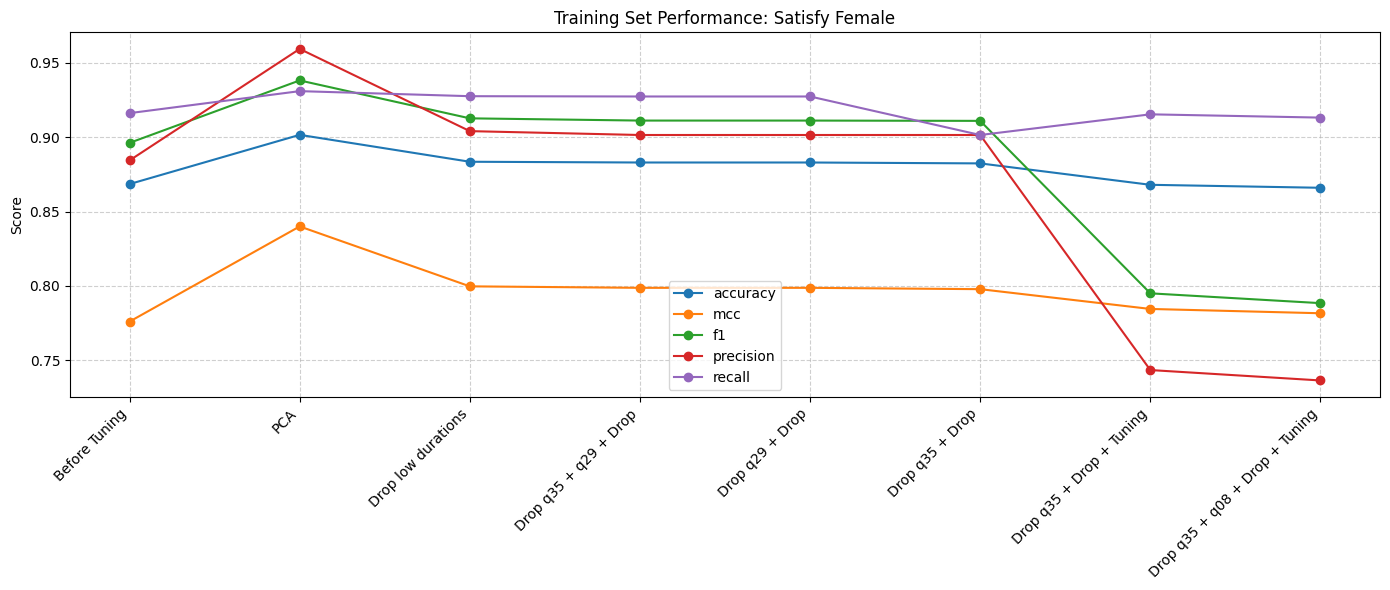

In [130]:
import pandas as pd
import matplotlib.pyplot as plt

data = {
    "Steps": [
        "Before Tuning",
        "PCA",
        "Drop low durations",
        "Drop q35 + q29 + Drop",
        "Drop q29 + Drop",
        "Drop q35 + Drop",
        "Drop q35 + Drop + Tuning",
        "Drop q35 + q08 + Drop + Tuning"
    ],
    "accuracy": [0.8685, 0.9016, 0.8835, 0.8830, 0.8830, 0.8824, 0.8680, 0.8660],
    "mcc": [0.7760, 0.8400, 0.7997, 0.7987, 0.7987, 0.7978, 0.7845, 0.7816],
    "f1": [0.8962, 0.9382, 0.9127, 0.9112, 0.9112, 0.9110, 0.7950, 0.7884],
    "precision": [0.8844, 0.9594, 0.9041, 0.9015, 0.9015, 0.9015, 0.7434, 0.7364],
    "recall": [0.9162, 0.9310, 0.9276, 0.9274, 0.9274, 0.9015, 0.9154, 0.9132],
}


df = pd.DataFrame(data)
df.set_index("Steps", inplace=True)

# Plot all metrics on the same graph
plt.figure(figsize=(14, 6))
for metric in df.columns:
    plt.plot(df.index, df[metric], marker='o', label=metric)

plt.title("Training Set Performance: Satisfy Female")
plt.ylabel("Score")
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


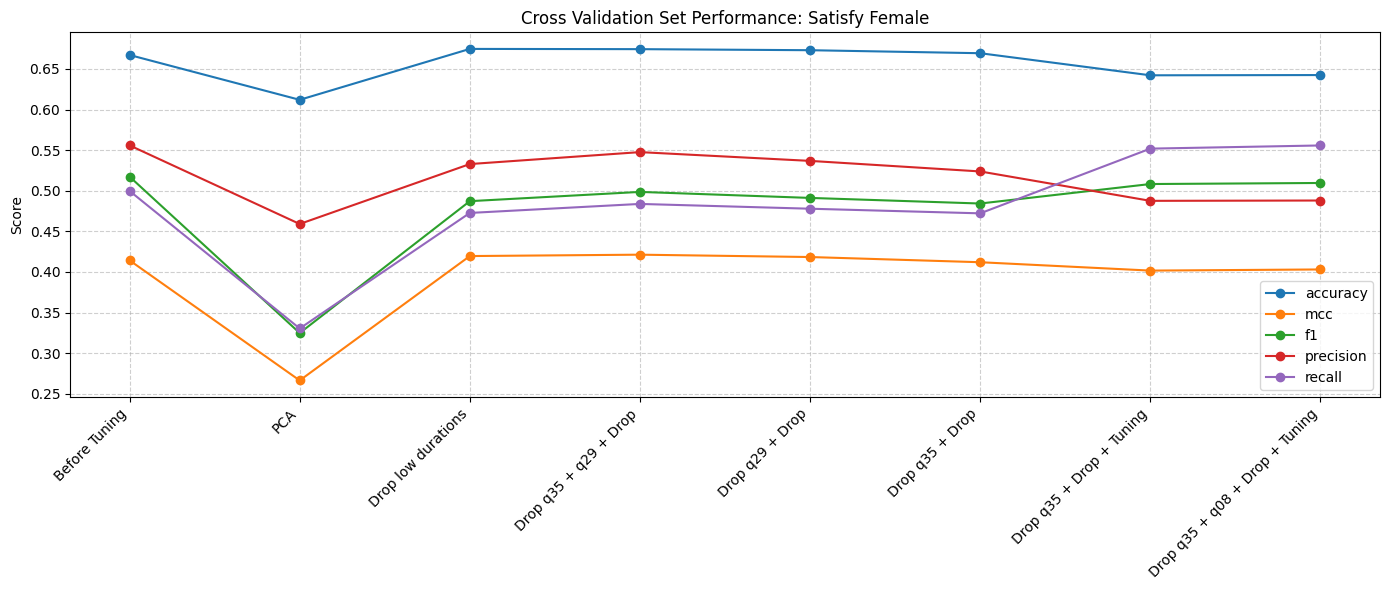

In [131]:
import pandas as pd
import matplotlib.pyplot as plt

# cross val 

data= {
    "Steps": [
        "Before Tuning",
        "PCA",
        "Drop low durations",
        "Drop q35 + q29 + Drop",
        "Drop q29 + Drop",
        "Drop q35 + Drop",
        "Drop q35 + Drop + Tuning",
        "Drop q35 + q08 + Drop + Tuning"
    ],
    "accuracy": [0.6672, 0.6120, 0.6747, 0.6744, 0.6731, 0.6694, 0.6422, 0.6425],
    "mcc": [0.4143, 0.2664, 0.4196, 0.4213, 0.4184, 0.4120, 0.4017, 0.4031],
    "f1": [0.5174, 0.3248, 0.4872, 0.4986, 0.4912, 0.4843, 0.5083, 0.5096],
    "precision": [0.5559, 0.4591, 0.5329, 0.5476, 0.5368, 0.5238, 0.4876, 0.4880],
    "recall": [0.4998, 0.3304, 0.4727, 0.4838, 0.4779, 0.4722, 0.5519, 0.5558],
}





df = pd.DataFrame(data)
df.set_index("Steps", inplace=True)

# Plot all metrics on the same graph
plt.figure(figsize=(14, 6))
for metric in df.columns:
    plt.plot(df.index, df[metric], marker='o', label=metric)

plt.title("Cross Validation Set Performance: Satisfy Female")
plt.ylabel("Score")
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


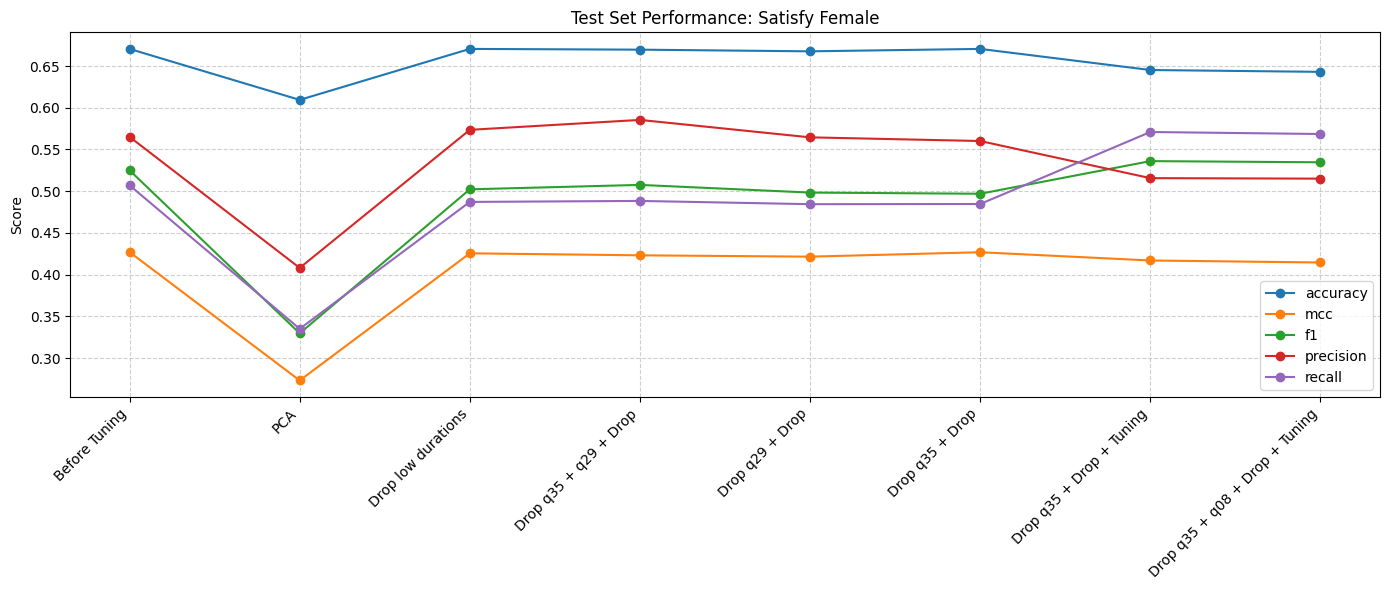

In [133]:
import pandas as pd
import matplotlib.pyplot as plt

# test

# Updated data for the new experiment (presumably another variation of Satisfy Male)
data = {
    "Steps": [
        "Before Tuning",
        "PCA",
        "Drop low durations",
        "Drop q35 + q29 + Drop",
        "Drop q29 + Drop",
        "Drop q35 + Drop",
        "Drop q35 + Drop + Tuning",
        "Drop q35 + q08 + Drop + Tuning"
    ],
    "accuracy": [0.6705, 0.6094, 0.6705, 0.6696, 0.6676, 0.6705, 0.6452, 0.6430],
    "mcc": [0.4270, 0.2731, 0.4255, 0.4231, 0.4215, 0.4268, 0.4169, 0.4145],
    "f1": [0.5250, 0.3296, 0.5022, 0.5075, 0.4983, 0.4969, 0.5360, 0.5346],
    "precision": [0.5651, 0.4080, 0.5735, 0.5854, 0.5645, 0.5601, 0.5156, 0.5150],
    "recall": [0.5070, 0.3350, 0.4871, 0.4883, 0.4844, 0.4846, 0.5709, 0.5685],
}


df = pd.DataFrame(data)
df.set_index("Steps", inplace=True)

# Plot all metrics on the same graph
plt.figure(figsize=(14, 6))
for metric in df.columns:
    plt.plot(df.index, df[metric], marker='o', label=metric)

plt.title("Test Set Performance: Satisfy Female")
plt.ylabel("Score")
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


## Fulfill Male

In [142]:
drop_features = ["form_start","form_end","q71","q08","q06"]
binary_features = [f"q{str(i).zfill(2)}" for i in range(1, 61) if i not in [8,6]] + ["q72"]
multi_label_binary = ["q63","q64","q65","q66","q67","q74", "q73"]
one_hot_features = ["q68","q69","q70"]


pfm = ColumnTransformer([
    ("duration_pipeline", Pipeline([
        ("compute", FunctionTransformer(compute_duration, validate=False, 
            feature_names_out=lambda self, input_features: np.array(["duration"]))),
        ("scale", MinMaxScaler())
    ]), drop_features),
    ("drop_cols", "drop", drop_features), 
    ("minmax_q61", MinMaxScaler(), ["q61"]),
    ("binary_encoding", FunctionTransformer(binary_transform, validate=False, feature_names_out='one-to-one'), binary_features), 
    ("multiselect", MultiHotEncoder(), multi_label_binary),
    ("onehot", OneHotEncoder(handle_unknown="ignore",sparse_output=False), one_hot_features),
], remainder="passthrough")  

os.makedirs("saved_models", exist_ok=True)

X_train = fulfill_male_train.drop(columns=["q62"])
y_train = fulfill_male_train["q62"]


def evaluate_model(name, classifier):
    pipeline = Pipeline([
        ("preprocessing", pfm),
        ("classifier", classifier)
    ])
    scoring = {
        'accuracy': 'accuracy',
        'mcc': make_scorer(matthews_corrcoef),
        'f1': 'f1_macro',
        'precision': make_scorer(precision_score, zero_division=1, average='macro'),
        'recall': make_scorer(recall_score, zero_division=1, average='macro')
    }

    cv_results = cross_validate(pipeline, X_train, y_train, cv=4, scoring=scoring, return_train_score=True, n_jobs=-1)

    print(f"\n{name}")
    print(f"{'Metric':<20}{'Train Avg':>12}{'Test Avg':>12}")
    print("-" * 60)
    for metric in scoring:
        train_scores = cv_results[f"train_{metric}"]
        test_scores = cv_results[f"test_{metric}"]
        print(f"{metric:<20}{np.mean(train_scores):>12.4f}{np.mean(test_scores):>12.4f}")
    
    # Return both: scores and the pipeline
    return {metric: cv_results[f"test_{metric}"] for metric in scoring}, pipeline
base_models = [
    ("Voting", VotingClassifier(n_jobs=-1  ,estimators=[
        ("hgb", HistGradientBoostingClassifier(
            learning_rate=0.02883701168472723, max_iter=312, max_leaf_nodes=37, min_samples_leaf=15,
            max_depth=7, l2_regularization=0.3398231196727128, early_stopping=True,
            n_iter_no_change=15, random_state=42, class_weight="balanced"
        )),
        ("RandomForest", RandomForestClassifier(
            n_estimators=379,             
            max_depth=18,              
            min_samples_split=5,         
            min_samples_leaf=3,           
            max_features="sqrt",      
            class_weight="balanced",     
            bootstrap=False,              
            random_state=42,
            n_jobs=-1                    
        )),
    ], voting='soft')),
]

cv_scores_fm = {}

for name, clf in base_models:
    model_scores, pipeline = evaluate_model(name, clf)  

    for metric, scores in model_scores.items():
        if metric not in cv_scores_fm:
            cv_scores_fm[metric] = {}
        cv_scores_fm[metric][name] = scores

    # pipeline.fit(X_train, y_train)

    # filename = f"saved_models/{name.replace(' ', '_').lower()}.dill"
    # with open(filename, "wb") as f:
    #     dill.dump(pipeline, f)

    
# Final test set evaluation
pipeline.fit(X_train, y_train)

X_test = fulfill_male_test.drop(columns=["q62"])
y_test = fulfill_male_test["q62"]

y_pred = pipeline.predict(X_test)

print("\nFinal Evaluation on Test Set (fulfill_male_test):")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred, average='macro'):.4f}")
print(f"Precision: {precision_score(y_test, y_pred, average='macro', zero_division=1):.4f}")
print(f"Recall: {recall_score(y_test, y_pred, average='macro', zero_division=1):.4f}")
print(f"MCC: {matthews_corrcoef(y_test, y_pred):.4f}")


Voting
Metric                 Train Avg    Test Avg
------------------------------------------------------------
accuracy                  0.9650      0.5773
mcc                       0.9482      0.3642
f1                        0.9586      0.4976
precision                 0.9431      0.5170
recall                    0.9767      0.4901

Final Evaluation on Test Set (fulfill_male_test):
Accuracy: 0.6220
F1 Score: 0.5519
Precision: 0.5763
Recall: 0.5439
MCC: 0.4390


In [140]:
X_train_transformed = pfm.fit_transform(X_train, y_train)
feature_names = []

for name, transformer, cols in pfm.transformers_:
    if name == "drop_cols":
        continue
    if hasattr(transformer, "get_feature_names_out"):
        if isinstance(cols, list):
            names = transformer.get_feature_names_out(cols)
        else:
            names = transformer.get_feature_names_out()
        feature_names.extend(names)
    else:
        if isinstance(cols, list):
            feature_names.extend(cols)
        else:
            feature_names.append(cols)

X_transformed_df = pd.DataFrame(X_train_transformed, columns=feature_names)


X_transformed_df.corrwith(y_train).sort_values(key=lambda x: abs(x), ascending=False)



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


q67_7   -0.203144
q37      0.187072
q73_4    0.164124
q66_4   -0.161444
q73_5    0.161353
           ...   
q39      0.007473
q63_2   -0.007348
q53     -0.003852
q65_6   -0.002863
q70_9         NaN
Length: 126, dtype: float64

## Fulfill Female

In [141]:
drop_features = ["form_start","form_end","q71","q22","q31"]
binary_features = [f"q{str(i).zfill(2)}" for i in range(1, 61) if i not in [22, 31]] + ["q72"]
multi_label_binary = ["q63","q64","q65","q66","q67","q74", "q73"]
one_hot_features = ["q68","q69","q70"]

pff = ColumnTransformer([
    ("duration_pipeline", Pipeline([
        ("compute", FunctionTransformer(compute_duration, validate=False, 
            feature_names_out=lambda self, input_features: np.array(["duration"]))),
        ("scale", MinMaxScaler())
    ]), drop_features),
    ("drop_cols", "drop", drop_features),  
    ("minmax_q61", MinMaxScaler(), ["q61"]),
    ("binary_encoding", FunctionTransformer(binary_transform, validate=False, feature_names_out='one-to-one'), binary_features), 
    ("multiselect", MultiHotEncoder(), multi_label_binary),
    ("onehot", OneHotEncoder(handle_unknown="ignore",sparse_output=False), one_hot_features),
], remainder="passthrough")  

os.makedirs("saved_models", exist_ok=True)

X_train = fulfill_female_train.drop(columns=["q62"])
y_train = fulfill_female_train["q62"]

def evaluate_model(name, classifier):
    pipeline = Pipeline([
        ("preprocessing", pff),
        ("classifier", classifier)
    ])
    scoring = {
        'accuracy': 'accuracy',
        'mcc': make_scorer(matthews_corrcoef),
        'f1': 'f1_macro',
        'precision': make_scorer(precision_score, zero_division=1, average='macro'),
        'recall': make_scorer(recall_score, zero_division=1, average='macro')
    }

    cv_results = cross_validate(pipeline, X_train, y_train, cv=4, scoring=scoring, return_train_score=True, n_jobs=-1)

    print(f"\n{name}")
    print(f"{'Metric':<20}{'Train Avg':>12}{'Test Avg':>12}")
    print("-" * 60)
    for metric in scoring:
        train_scores = cv_results[f"train_{metric}"]
        test_scores = cv_results[f"test_{metric}"]
        print(f"{metric:<20}{np.mean(train_scores):>12.4f}{np.mean(test_scores):>12.4f}")
    
    # Return both: scores and the pipeline
    return {metric: cv_results[f"test_{metric}"] for metric in scoring}, pipeline
base_models = [
    ("Voting", VotingClassifier(n_jobs=-1  ,estimators=[
        ("hgb", HistGradientBoostingClassifier(
            learning_rate=0.02883701168472723, max_iter=312, max_leaf_nodes=37, min_samples_leaf=15,
            max_depth=7, l2_regularization=0.3398231196727128, early_stopping=True,
            n_iter_no_change=15, random_state=42, class_weight="balanced"
        )),
        ("RandomForest", RandomForestClassifier(
            n_estimators=379,             
            max_depth=18,              
            min_samples_split=5,         
            min_samples_leaf=3,           
            max_features="sqrt",      
            class_weight="balanced",     
            bootstrap=False,              
            random_state=42,
            n_jobs=-1                    
        )),
    ], voting='soft')),
]

cv_scores_ff = {}

for name, clf in base_models:
    model_scores, pipeline = evaluate_model(name, clf)  

    for metric, scores in model_scores.items():
        if metric not in cv_scores_ff:
            cv_scores_ff[metric] = {}
        cv_scores_ff[metric][name] = scores

    # pipeline.fit(X_train, y_train)

    # filename = f"saved_models/{name.replace(' ', '_').lower()}.dill"
    # with open(filename, "wb") as f:
    #     dill.dump(pipeline, f)

    
# Final test set evaluation
pipeline.fit(X_train, y_train)

X_test = fulfill_female_test.drop(columns=["q62"])
y_test = fulfill_female_test["q62"]

y_pred = pipeline.predict(X_test)

print("\nFinal Evaluation on Test Set (fulfill_female_test):")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred, average='macro'):.4f}")
print(f"Precision: {precision_score(y_test, y_pred, average='macro', zero_division=1):.4f}")
print(f"Recall: {recall_score(y_test, y_pred, average='macro', zero_division=1):.4f}")
print(f"MCC: {matthews_corrcoef(y_test, y_pred):.4f}")


Voting
Metric                 Train Avg    Test Avg
------------------------------------------------------------
accuracy                  0.8921      0.6205
mcc                       0.8285      0.4000
f1                        0.8915      0.5203
precision                 0.8595      0.5372
recall                    0.9326      0.5170

Final Evaluation on Test Set (fulfill_female_test):
Accuracy: 0.6179
F1 Score: 0.5257
Precision: 0.5423
Recall: 0.5207
MCC: 0.3937


In [61]:
X_train_transformed = pff.fit_transform(X_train, y_train)
feature_names = []

for name, transformer, cols in pff.transformers_:
    if name == "drop_cols":
        continue
    if hasattr(transformer, "get_feature_names_out"):
        if isinstance(cols, list):
            names = transformer.get_feature_names_out(cols)
        else:
            names = transformer.get_feature_names_out()
        feature_names.extend(names)
    else:
        if isinstance(cols, list):
            feature_names.extend(cols)
        else:
            feature_names.append(cols)

X_transformed_df = pd.DataFrame(X_train_transformed, columns=feature_names)


X_transformed_df.corrwith(y_train).sort_values(key=lambda x: abs(x), ascending=False)



q69_4    0.028674
q64_3    0.019624
q51     -0.018969
q64_5   -0.018907
q69_5   -0.018634
           ...   
q65_6    0.000349
q65_2    0.000329
q08      0.000295
q70_4    0.000105
q06     -0.000043
Length: 126, dtype: float64

## ANOVA

In [143]:
from scipy.stats import f_oneway

def compare_groups(cv_scores_male, cv_scores_female, dataset_name):
    print(f"\nANOVA Results for {dataset_name} (Male vs Female)")
    for metric in cv_scores_male:
        print(f"\nMetric: {metric}")
        for model in cv_scores_male[metric]:
            if model in cv_scores_female[metric]:
                male_scores = cv_scores_male[metric][model]
                female_scores = cv_scores_female[metric][model]
                
                f_val, p_val = f_oneway(male_scores, female_scores)
                print(f"  {model}: F = {f_val:.4f}, p = {p_val:.4f}", end=" ")
                if p_val < 0.05:
                    print("→ Significant difference")
                else:
                    print("→ Not significant")

In [146]:
compare_groups(cv_scores_sm, cv_scores_sf, "Satisfy Models")
compare_groups(cv_scores_fm, cv_scores_ff, "Fulfill Models")



ANOVA Results for Satisfy Models (Male vs Female)

Metric: accuracy
  Voting: F = 1.8433, p = 0.2234 → Not significant

Metric: mcc
  Voting: F = 0.0000, p = 0.9986 → Not significant

Metric: f1
  Voting: F = 0.0366, p = 0.8546 → Not significant

Metric: precision
  Voting: F = 2.6324, p = 0.1558 → Not significant

Metric: recall
  Voting: F = 2.7053, p = 0.1511 → Not significant

ANOVA Results for Fulfill Models (Male vs Female)

Metric: accuracy
  Voting: F = 39.3380, p = 0.0008 → Significant difference

Metric: mcc
  Voting: F = 9.6871, p = 0.0208 → Significant difference

Metric: f1
  Voting: F = 3.8751, p = 0.0965 → Not significant

Metric: precision
  Voting: F = 4.6041, p = 0.0756 → Not significant

Metric: recall
  Voting: F = 3.8458, p = 0.0975 → Not significant
